In [2]:
import pandas as pd
import datetime as dt
from datetime import datetime,timedelta
import matplotlib
import matplotlib.pyplot as plt
import math

### Current Code:

In [18]:
def forecast_sales(start_date: datetime, end_date: datetime, sales_data: pd.DataFrame):
    
    days_to_forecast = (end_date - start_date).days
    mean_daily_sales = sales_data[sales_data['date'] < start_date]['sales'].mean()
    return mean_daily_sales * days_to_forecast

In [19]:
def calculate_new_order (order_date: datetime, lead_time_days: int, days_to_next_order: int, 
                         sales_data: pd.DataFrame, current_stock_level: int, stock_in_transit: int):
    
    arrival_date = order_date + timedelta(days=lead_time_days)
    next_arrival_date = order_date + timedelta(days=days_to_next_order + lead_time_days)
    
    forecast_leadtime = forecast_sales(order_date, arrival_date, sales_data)
    estimated_stock_at_arrival = current_stock_level - forecast_leadtime + stock_in_transit 
    
    forecast_planning_horizon = forecast_sales(arrival_date,next_arrival_date, sales_data)
    order = max(0,forecast_planning_horizon - estimated_stock_at_arrival)
    return order

### Calculate Reordering


In [20]:
order_date = datetime(2020,6,1)
lead_time_days = 90
days_to_next_order = 30
current_stock_level = 400
stock_in_transit = 600

<AxesSubplot:xlabel='date', ylabel='sales'>

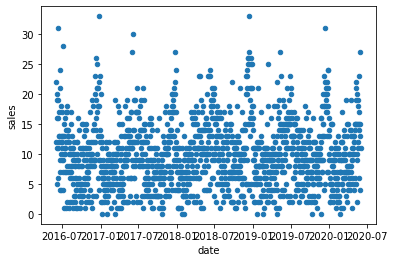

In [21]:
sales_data = pd.read_csv('sales_data.csv',parse_dates=['date'])
sales_data.plot.scatter(x='date',y='sales')

In [22]:
calculate_new_order (order_date=order_date, 
                   lead_time_days=lead_time_days, 
                   days_to_next_order=days_to_next_order, 
                   sales_data=sales_data, 
                   current_stock_level=current_stock_level, 
                   stock_in_transit=stock_in_transit)


186.0598684820378

In [23]:
def calc_losses(lost_sales, stock_track):
    # This function calculates the losses derived from overstorage and lost sales because of shortage
    
    units_daily_overstock = 0 #Tracks how many product units stay on the warehouse one day
    for entry in stock_track:
        units_daily_overstock += entry[1]
    overstock_costs = units_daily_overstock * 0.25 / 30 # We assume that storage costs are linear. DOUBLE CHECK THIS
    lost_sales_cost = lost_sales*(25-10) 
    print("Losses due to lost sales: {:.2f}€".format(lost_sales_cost))
    print("Costs due to stock excess: {:.2f}€".format(overstock_costs))
    print("Total costs derived from stock management: {:.2f}€".format(overstock_costs + lost_sales_cost))
    return overstock_costs + lost_sales_cost

In [24]:
def test_algorithm(sales_data: pd.DataFrame, lead_time_days = 90, days_to_next_order = 30, current_stock_level = 400, stock_in_transit = 600):
    sorted_sales = sales_data.sort_values('date', ascending = True)	# If the input data is not sorted, it re-aranges it

    initial_date = sales_data.iloc[0]['date']
    final_date = sales_data.iloc[-1]['date']
    
    total_period = final_date - initial_date # Days between the first and last entries

    measure_date = initial_date
    # We do not have the real data. We will use the one provided for June 1st, 2020 as a reference
    stock_track = [] # For every day, it stores the date and stock available
    days_until_next_order = days_to_next_order # To keep track on the order dates
    
    orders_and_arrivals = [[initial_date + timedelta(days=days_to_next_order), stock_in_transit/2],[initial_date + timedelta(days=2*days_to_next_order), stock_in_transit/2]]
    # List that stores every order arrival date and amount ordered. Since we don't have data, we assume that the first two orders are of 300 each
    
    lost_sales = 0 # Units unsold because of stock shortage
    
    while pd.to_datetime(measure_date) < pd.to_datetime(final_date):
        for order in orders_and_arrivals: # We check if there are orders that have arrived, and add them to the stock
            if order[0] == measure_date:
                current_stock_level += order[1]
                stock_in_transit -= order[1]
                # Uncomment to see the placed orders.
                # print("Order at {} of {} units".format(order[0], order[1]))
            
        if days_until_next_order == 0: # If the due date arrives, we launch a new order and update stock in transit
            new_order = math.ceil(calculate_new_order(order_date=measure_date, lead_time_days=lead_time_days, days_to_next_order=days_to_next_order, sales_data=sales_data, current_stock_level=current_stock_level, stock_in_transit=stock_in_transit))
            orders_and_arrivals.append([measure_date + timedelta(days=lead_time_days), new_order])
            stock_in_transit += new_order 
            days_until_next_order = days_to_next_order
        
        # For every day, we acknowledge the daily sales, keep track of the stock and add both to the list
        
        day_sales = sales_data.loc[sales_data['date'] == measure_date]['date'].item()
        current_stock_level -= sales_data.loc[sales_data['date'] == measure_date]['sales'].item()
        if(current_stock_level < 0): # Stock cannot be lower than 0
            lost_sales -= current_stock_level
            current_stock_level = 0
            
        stock_track.append([day_sales, current_stock_level])
        measure_date += timedelta(days=1)
        days_until_next_order -= 1
       
    plt.plot([date[0] for date in stock_track], [stock[1] for stock in stock_track]) #When we are done with every day, we plot the results
    plt.show()
    
    return calc_losses(lost_sales=lost_sales, stock_track=stock_track)
      
    

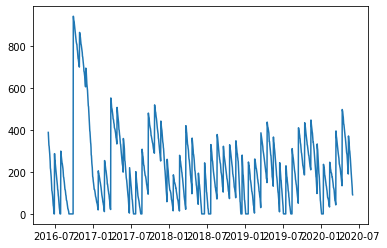

Losses due to lost sales: 16890.00€
Costs due to stock excess: 2689.96€
Total costs derived from stock management: 19579.96€


In [25]:
original_approach = test_algorithm(sales_data)

In [26]:
def forecast_sales(start_date: datetime, end_date: datetime, sales_data: pd.DataFrame):
    #A first apporach will be with a moving average of the last 15 days
    
    #First: take the last data entrie that contains the day and month of the end_date and start_date
    last_end_date = end_date - timedelta(days=365)
    last_start_date = start_date - timedelta(days=365)
    
    #Check that period's sales
    if sales_data[sales_data['date'] < last_start_date]['sales'].sum() > 0: #There is data
        last_sales = sales_data[(sales_data['date'] > last_start_date) & (sales_data['date'] < last_end_date)]['sales'].sum()
    else: # If there is no data, we use the next semester's data, because the period is about half a year
        start_date += timedelta(days=180)
        end_date += timedelta(days=180)
        last_sales = forecast_sales(start_date=start_date, end_date=end_date, sales_data=sales_data)
    
    return last_sales

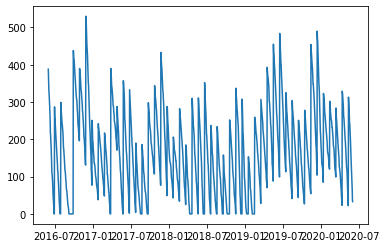

Losses due to lost sales: 14730.00€
Costs due to stock excess: 2051.14€
Total costs derived from stock management: 16781.14€


In [27]:
improved_approach = test_algorithm(sales_data)

In [30]:
print("Total improvement: {:.2f}€".format(original_approach-improved_approach))
print("Relative improvement:  {:.2f}%".format((original_approach-improved_approach)/original_approach*100))

Total improvement: 2798.82€
Relative improvement:  14.29%
